## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep learning model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**QUESTION:** Load dataset and display some lines of the csv file.

In [ ]:
dataset_file = open("/content/drive/MyDrive/EMSE/Projet_IA_Embarquee/ai4i2020.csv")
dataset = dataset_file.readlines()

# display a few lines
for i in range(2, 6):
  print(dataset[i])

2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0

3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0

4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0

5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0



**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

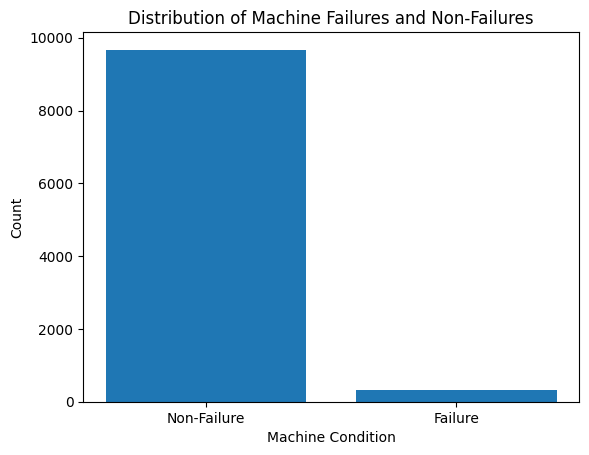

In [ ]:
# Extract the relevant columns for failures
failure_columns = [line.split(',')[9:15] for line in dataset[1:]]

# Count the occurrences of failures and non-failures
failure_counts = [0, 0]
for row in failure_columns:
    if '1' in row:
        failure_counts[1] += 1
    else:
        failure_counts[0] += 1

# Plot the bar graph
plt.bar(['Non-Failure', 'Failure'], failure_counts)
plt.xlabel('Machine Condition')
plt.ylabel('Count')
plt.title('Distribution of Machine Failures and Non-Failures')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

On constate qu'il n'y à que peu de cas de Failure dans le dataset.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

Avoir si peu d'exemples de cas de Failure risque de faire apprendre par coeur au modèles les données d'entrainement. Par conséquent le modèle ne pourra pas correctement généraliser sur les données et sera très bon à l'entrainement et mauvais en inférence (overfitting). Il faut construire le modèle en tenant en compte cette caractéristique du dataset.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

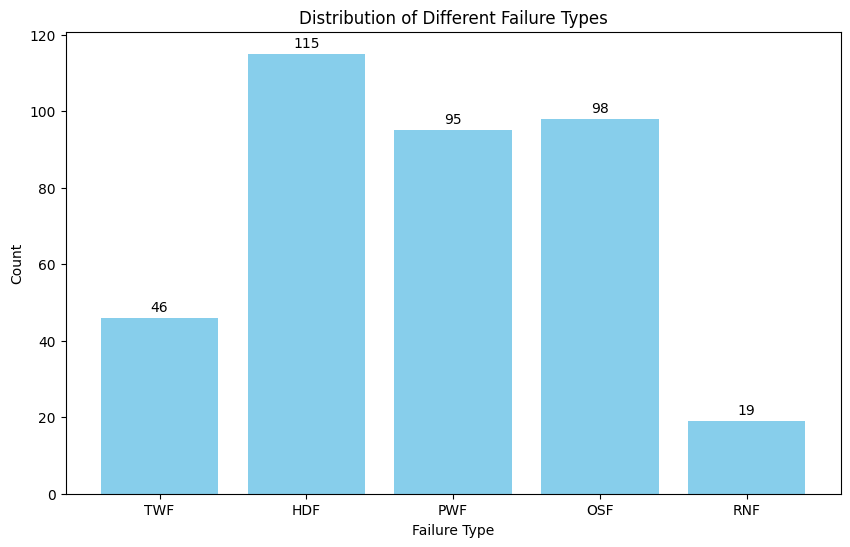

In [ ]:
# Extract the relevant columns for each failure type
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]
failure_counts = [0, 0, 0, 0, 0]

for row in dataset[1:]:
    columns = row.rstrip().split(',')
    for i in range(5):
        if columns[9 + i] == '1':
            failure_counts[i] += 1

# Plot the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(failure_types, failure_counts, color='skyblue')

# Display the exact values above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Different Failure Types')
plt.show()

**ANALYSIS QUESTION:** What do you observe?

On constate que les Failures sont assez bien réparties entre les catégories. Les catégories HDF, PWF, OSF ont les plus de cas de Failure et sont équivalentes en termes de nombre de machines.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

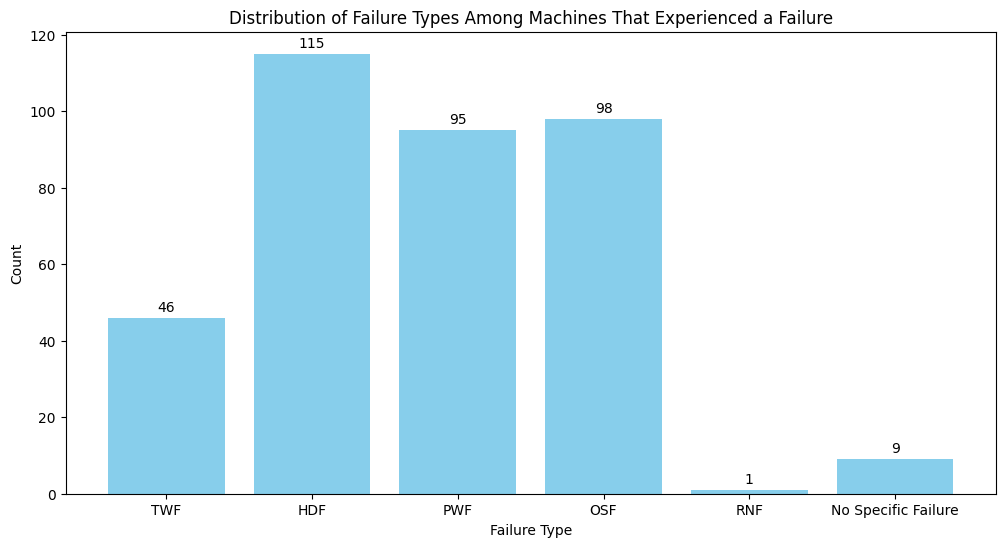

In [ ]:
# Extract the relevant columns for each failure type and machine failure
failure_types = ["TWF", "HDF", "PWF", "OSF", "RNF"]
failure_counts = [0, 0, 0, 0, 0]
no_specific_failure_count = 0

for row in dataset[1:]:
    columns = row.rstrip().split(',')
    if columns[8] == '1':  # Check if there is any machine failure
        specific_failures = sum([1 for i in range(5) if columns[9 + i] == '1'])
        if specific_failures == 0:
            no_specific_failure_count += 1
        else:
            for i in range(5):
                if columns[9 + i] == '1':
                    failure_counts[i] += 1

# Add the "No Specific Failure" category
failure_types.append("No Specific Failure")
failure_counts.append(no_specific_failure_count)

# Plot the bar chart
plt.figure(figsize=(12, 6))
bars = plt.bar(failure_types, failure_counts, color='skyblue')

# Display the exact values above each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha='center', va='bottom')

plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.title('Distribution of Failure Types Among Machines That Experienced a Failure')
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

On constate qu'il n'y a qu'une seule Failure RNF qui a été détectée et classifiée. 9 autres ont été détectées mais pas classifiées. Enfin, 9 autres n'ont pas du tout été détectées. On peut en conclure qu'il est difficile de détecter les Failures de type RNF et qu'on ne pourra pas entrainer le modèle à les détecter (trop peu de données).

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [ ]:
# Extract the header row
header = dataset[0].rstrip().split(',')

# Initialize a dictionary to store column names and their inferred data types
column_types = {col: 'Unknown' for col in header}

# Infer data types from the first data row
first_data_row = dataset[1].rstrip().split(',')

for i, value in enumerate(first_data_row):
    try:
        int(value)
        column_types[header[i]] = 'int'
    except ValueError:
        try:
            float(value)
            column_types[header[i]] = 'float'
        except ValueError:
            column_types[header[i]] = 'str'

# Display the column names and their inferred data types
for col, dtype in column_types.items():
    print(f'{col}: {dtype}')

﻿UDI: int
Product ID: str
Type: str
Air temperature [K]: float
Process temperature [K]: float
Rotational speed [rpm]: int
Torque [Nm]: float
Tool wear [min]: int
Machine failure: int
TWF: int
HDF: int
PWF: int
OSF: int
RNF: int


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to justify your response.

Inputs du modèle:
- Air temp
- Process temp
- Rotational speed
- Torque
- Tool wear

Outputs du modèle:
- TWF
- HDF
- PWF
- OSF
- NF (No failure)

Informations retirées des outpus:

* NRF: car on a trop peu de données pour pouvoir entrainer le modèle à prédire ce type de panne.
* NSF (No Specific Failure): On a pas d'information claire sur comment détecter ce type de panne. De plus on nous demande de détecter et classifier.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [94]:
# on cree les set de donnees pour le modele
X = []

for line in dataset[1:]:
  line_str = line.split(",")
  line_float = np.float64(line_str[3:])
  print(line_float)

  X.append(np.concatenate((line_float[0:5], [line_float[2] * line_float[3]])))


# X = [np.float64(line.split(",")[3:8]) for line in dataset[1:]]

Y = []
for line in dataset[1:]:
  if(sum(np.int64(line.split(",")[9:13])) == 0):
    Y.append(np.int64([0, 0, 0, 0, 1]))
  else:
    Y.append(np.int64(line.split(",")[9:13] + [0]))

# X : [<Air temp>, <Process temp>, <Rot speed>, <Torque>, <Tool wear>]
# Y : [<TWF>, <HDF>, <PWF>, <OSF>, <NF>] (NF pour No Faillure)

print(X)
print(Y)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
       5.92515e+04]), array([3.03300e+02, 3.11600e+02, 1.48400e+03, 4.46000e+01, 2.23000e+02,
       6.61864e+04]), array([3.03200e+02, 3.11500e+02, 1.50700e+03, 3.92000e+01, 2.25000e+02,
       5.90744e+04]), array([3.032e+02, 3.115e+02, 1.544e+03, 4.250e+01, 2.270e+02, 6.562e+04]), array([3.03200e+02, 3.11500e+02, 1.51300e+03, 3.79000e+01, 0.00000e+00,
       5.73427e+04]), array([3.03200e+02, 3.11500e+02, 1.33600e+03, 5.82000e+01, 2.00000e+00,
       7.77552e+04]), array([3.0320e+02, 3.1140e+02, 2.1020e+03, 1.9000e+01, 5.0000e+00,
       3.9938e+04]), array([3.03200e+02, 3.11400e+02, 1.35100e+03, 5.38000e+01, 8.00000e+00,
       7.26838e+04]), array([3.03300e+02, 3.11500e+02, 1.60100e+03, 3.52000e+01, 1.00000e+01,
       5.63552e+04]), array([3.03200e+02, 3.11300e+02, 1.39300e+03, 5.29000e+01, 1.20000e+01,
       7.36897e+04]), array([3.03300e+02, 3.11300e+02, 1.59200e+03, 3.37000e+01, 1.40000e+01,
       

In [ ]:
# POUR LA NORMALISATION
from scipy.stats import zscore

# Iterate over the columns in the dataframe
for col in X.columns:
  # Normalize the values in the column
  X[col] = zscore(X[col])


# CREATION DES DATASET TRAIN et TEST

# Split the dataset into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.60, random_state=42)

# Print the sizes of the resulting datasets
print(f"X_train size: {X_train.shape}")
print(f"y_train size: {Y_train.shape}")
print(f"X_test size: {X_test.shape}")
print(f"y_test size: {Y_test.shape}")


**QUESTION** Code below the model architecture

**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

"Write your response here"

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

**QUESTION** Code below the algorithms allowing to train model


**QUESTION** Plot the confusion matrix and the classification report

**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"